# Monophonic Pitch Transcription
This notebook is meant to be a step by step guide on performing monophonic pitch transcription for a single channel audio recording. (In this case I demonostrate with a lick played on an acoustic guitar). 

This notebook is meant to be a guide.


The output is then validated with a ground truth xml file.

### 1) Environment Setup

In [1]:
# Install librosa
print('Installing Librosa and dependencies...\n')

# TODO: Comment only for repeated testing. Uncomment for first run to install dependencies
!pip install -q librosa


# Importing os for file handling
import os

# and numpy for mathematical operations
import numpy as np

# and librosa for audio manipulation
import librosa 
import librosa.display

# for xml parsing
import xml.etree.ElementTree as ET

# for audio output
import IPython.display as ipd
from __future__ import print_function

# for visualiaztions
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 3)

SAMPLE_RATE = 48000
hop_length = 100
    
currentPath = os.getcwd()
inputPath = currentPath
outputPath = os.path.join(currentPath,'Output/')

try: 
    os.makedirs(outputPath)
except OSError:
    if not os.path.isdir(outputPath):
        raise

print('Sucess!! Environment is now setup.')

Installing Librosa and dependencies...



You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Populating the interactive namespace from numpy and matplotlib
Sucess!! Environment is now setup.


### 2) Observing the data
The data consists of 6 licks, each having 3 versions played on 3 different guitars. Lets take one of the sounds to examine.

In [2]:
# Change Filename to test for any other file in the Dataset

filename = 'Lick1.wav'
audioFile = os.path.join(inputPath, filename)

audio, sr = librosa.load(audioFile, SAMPLE_RATE)
ipd.Audio(audio, rate = SAMPLE_RATE)

#### Observing the Constant Q transform (CQT) of the signal.

Note : The CQT is similar to the DFT but unlike the DFT where the bin sizes across all the frequencies are constant, a CQT has a logrithmically spaced filter bank. This is though a little slower than the FFT implementation of the DFT, it is better suited for musical applications.

{Ref original paper - <a href="http://academics.wellesley.edu/Physics/brown/pubs/cq1stPaper.pdf">Judith C. Brown, "Calculation of a constant Q spectral transform," J. Acoust. Soc. Am., 89(1):425–434, 1991. </a> }

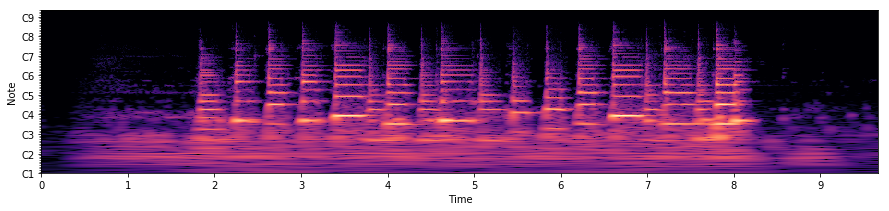

In [7]:
no_bins_per_octave = 36

cqt = librosa.cqt(audio, 
                  sr = SAMPLE_RATE, 
                  n_bins = 300, 
                  bins_per_octave = no_bins_per_octave)

cqt_mag = librosa.magphase(cqt, power = 2)[0]
log_cqt = librosa.power_to_db(cqt_mag)

librosa.display.specshow(log_cqt, 
                         sr = SAMPLE_RATE, 
                         x_axis = 'time', y_axis = 'cqt_note', 
                         bins_per_octave = no_bins_per_octave);

The processing of the audio files is divided into two parts. The first Onset detection stage (Timing) and the Pitch estimation stage (Tune). After the processing, evaluation is performed on the ground truth xml file provided.

In this jupyter notebook, the algorithm is run for one audio file. The provided monophonicTranscription.py implements a complete evaluation.

### 3) Onset  (Timing)

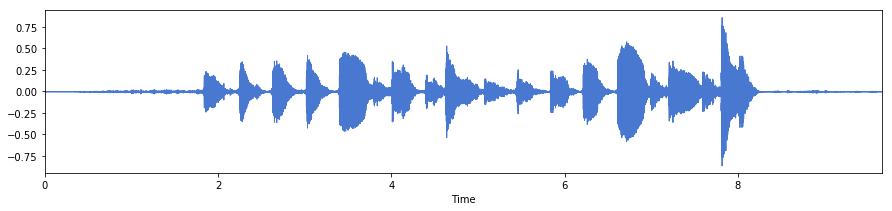

In [8]:
plt.figure()
librosa.display.waveplot(audio, sr = SAMPLE_RATE)

Onset Strength envelope is obtained as the smoothened spectral flux from the power log mel spectrogram of the audio signal.

(0, 4639)

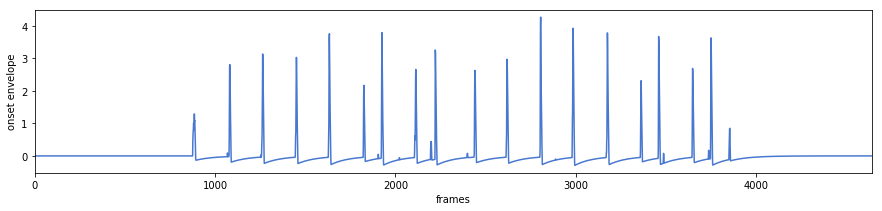

In [9]:
o_env = librosa.onset.onset_strength(audio, SAMPLE_RATE, 
                                     aggregate = np.median, 
                                     detrend = True,
                                     fmax = 10000, 
                                     n_mels = 256,
                                     hop_length = hop_length)

plt.plot(o_env)
plt.ylabel('onset envelope') 
plt.xlabel('frames')
plt.xlim(0,len(o_env))

Peaks are picked from the onset envelope giving us the onset boundaries

In [10]:
onset_samples = librosa.onset.onset_detect(onset_envelope = o_env,
                                           units='samples',
                                           sr = SAMPLE_RATE, 
                                           hop_length = hop_length,
                                           backtrack = False,
                                           pre_max = 20,
                                           post_max = 20,
                                           pre_avg = 100,
                                           post_avg = 100,
                                           delta = 0.1,
                                           wait = 0)

# Concatenating the last boundary as the end of file
onset_boundaries = np.concatenate([onset_samples, [len(audio)]])

In [11]:
onset_times = librosa.samples_to_time(onset_boundaries, sr = SAMPLE_RATE)
print(onset_boundaries)
print(len(onset_times))

[ 88600 108200 126400 145100 163400 182500 192500 211300 222100 244100
 261800 280500 298500 317500 336200 345900 364700 374900 385300 463872]
20


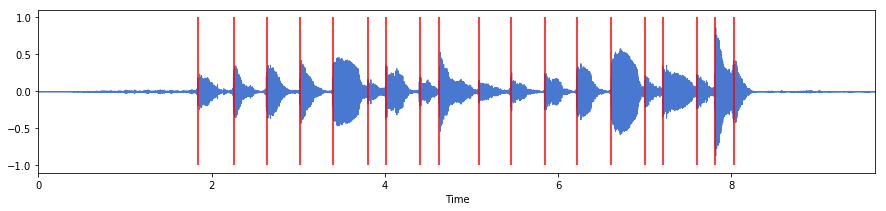

In [12]:
librosa.display.waveplot(audio, sr = SAMPLE_RATE)
plt.vlines(onset_times, -1, 1, color='r')

### 4) Estimating Pitch (Tune)

A simple autocorrelation is performed on each of the segments obtained from the detected onsets. A common method for pitch estimation is detecting the highest value of autocorrelation in the region of interest. If a signal has periodicity P samples, the autocorrelation of the signal also has the same periodicity P samples.

In [13]:
def pitch_segment(segment, sr, fmin=80.0, fmax=2000.0):
    
    # Autocorrelation of segment
    autocorr = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    autocorr[:int(i_min)] = 0
    autocorr[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = autocorr.argmax()
    f0 = float(sr)/i
    
    return f0

Create a F0 sequence for the entire audio

In [14]:
def estimate_pitch_segmentation(audio, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = pitch_segment(audio[n0:n1], sr)
    midi = int(np.rint(librosa.hz_to_midi(f0)))
    
    print(".", end = "")
    return midi
print("Processing autocorrelation in each onset segment")
midiSequence = [estimate_pitch_segmentation(audio, onset_boundaries, i, SAMPLE_RATE) for i in range(len(onset_boundaries)-1)]
print("\nPitch Estimation Successful!")

Processing autocorrelation in each onset segment
...................
Pitch Estimation Successful!


In [15]:
print(midiSequence)
print(onset_times[:-1])
onsetSequence = onset_times[:-1]

[44, 56, 54, 56, 59, 44, 54, 44, 56, 44, 49, 51, 54, 59, 44, 54, 44, 54, 56]
[1.84583333 2.25416667 2.63333333 3.02291667 3.40416667 3.80208333
 4.01041667 4.40208333 4.62708333 5.08541667 5.45416667 5.84375
 6.21875    6.61458333 7.00416667 7.20625    7.59791667 7.81041667
 8.02708333]


### 5) Evaluation against ground truth

Using the evaluation methods indicated in the problem statement provided and a reference to MIREX 2018 <a href = 'http://www.music-ir.org/mirex/wiki/2018:Audio_Onset_Detection'>(Onset Detections)</a>

* Onsets (Timing) : The detected onset times will be compared with the ground-truth ones. For a given ground-truth onset time, if there is a detection in a tolerance time-window around it (X msec), it is considered as a correct detection (CD). If not, there is a false negative (FN). The detections outside all the tolerance windows are counted as false positives (FP). With this we define

    * Precision P = CD / (CD + FP) 
    * Recall R = CD / (CD + FN)
    * F-measure F = 2*P*R/(P+R)

    
* Pitch (Tune) : Pitch is validated only for the correct detection (CD) onsets with the ground truth. 
    * Raw Pitch accuracy (RPA) : Note tune found to be correct if within X cents with ground truth. Since the ground truth is in midi. It is determined correct when exactly matching the midi value
    * Raw Chroma accuracy (RCA) : Note tune found to be correct disregarding octave errors, so the note name is identified correct. (For midi, this means that midi values separated by 12 are considered equivalent. Example - 57 A3 and 69 A4 are considered equivalent for RCA)



There are also other interesting evaluation metrics for merged onsets and duplicate onsets, which I do not investigate in this notebook.

In [29]:
groundtruthFilename = filename[:-4] + '.xml'
gtFile = os.path.join(inputPath,groundtruthFilename)

# Parsing the xml ground truth file
tree = ET.parse(gtFile)
root = tree.getroot()

In [30]:
# Generating the Ground Truth Sequences for Pitch and Onset
gtPitchSequence = [int(root[i][1].text) for i in range(len(root))]
gtOnsetSequence = [float(root[i][0].text) for i in range(len(root))]

#### Evaluation of Timing

In [31]:
# Because of the inaccuracy of ground truth annotations threshold shouldn't be < 0.05 (50msec)
onset_threshold = 0.06

def compare_onset_events(event, truth, onset_threshold):
    
    e_index = 0
    t_index = 0
    count_CD = 0.0
    count_FP = 0.0
    count_FN = 0.0
    
        
    # Array to keep track of the correctly detected onset positions, 
    # sequence
    sequence_CD = [-1] * len(onsetSequence)
    
    while t_index < len(truth):
        
        # Within threshold 
        if np.abs(event[e_index] - truth[t_index]) <= onset_threshold:
            
            #test
            #print("CD", event[e_index],truth[t_index])
            count_CD += 1
            sequence_CD[e_index] = int(t_index)
            t_index += 1
            e_index += 1
            
        # False Positive    
        elif event[e_index] < truth[t_index]:
            
            #test
            #print("FP", event[e_index],truth[t_index])
            e_index += 1
            count_FP += 1
        
        # False Negative
        else :
            
            #test
            #print("FN", event[e_index],truth[t_index])
            t_index += 1
            count_FN += 1
            
    return count_CD, count_FP, count_FN, sequence_CD

In [32]:
CD, FP, FN, sequence_CD = compare_onset_events(onsetSequence, gtOnsetSequence, onset_threshold)

Precision = CD / (CD + FP)
Recall = CD / (CD + FN)
Fmeasure = (2*Precision*Recall)/(Precision +Recall)
print("Correct Detections = ", CD," out of ", len(gtOnsetSequence) , "\nFalse Positives = ", FP, "\nFalse Negatives = ", FN, " \n\n")
print("Precision = ", Precision,"\nRecall =", Recall,"\nF-measure =", Fmeasure)

Correct Detections =  12.0  out of  13 
False Positives =  1.0 
False Negatives =  1.0  


Precision =  0.9230769230769231 
Recall = 0.9230769230769231 
F-measure = 0.9230769230769231


#### Evaluation of Tune

In [33]:
#Raw Pitch accuracy and Raw Chroma accuracy
nRPA = 0.0
nRCA = 0.0

for i in range(len(midiSequence)):
    if sequence_CD[i] != -1:
        #print(midiSequence[i], " ", gtPitchSequence[sequence_CD[i]], " ", i)
        if midiSequence[i] == gtPitchSequence[sequence_CD[i]]:
            nRPA += 1
            nRCA += 1
        elif abs(midiSequence[i] - gtPitchSequence[sequence_CD[i]]) % 12 == 0:
            nRCA += 1
RPA = nRPA/len(gtPitchSequence) * 100
RCA = nRCA/len(gtPitchSequence) * 100
OA = nRPA/len(midiSequence) * 100
print("Raw Pitch Accuracy = ", RPA, "\nRaw Chroma Accuracy =", RCA)
print("Overall Accuracy including all predicted onsets = ", OA)

Raw Pitch Accuracy =  84.61538461538461 
Raw Chroma Accuracy = 84.61538461538461
Overall Accuracy including all predicted onsets =  84.61538461538461
